# **Task 3: Style Recognition Model for Recommended Furniture**

In this task, we extend the model developed in Task 2 to ensure that the recommended furniture items not only match the category of the input image but also share the same interior style. This involves building a model capable of recognizing the style of a furniture item, enabling the recommendation system to provide items consistent with both the category and style of the input image.


### Loading Required Libraries

In this section, we will mount Google Drive to access the dataset and install the necessary libraries, such as TensorFlow, for our deep learning tasks.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install tensorflow

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
import numpy as np
from google.colab import files
from IPython.display import Image, display
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf

from tensorflow.keras.preprocessing import image

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from google.colab import files


## Step 1: Data Loading and Preprocessing

In this step, we import the necessary libraries and define the categories and interior styles of furniture. This sets up the initial environment for loading and preprocessing our dataset, which includes defining the categories of furniture and their corresponding interior styles.


In [5]:

categories = ['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']
interior_styles = ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse',
                   'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian',
                   'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']

## Step 2: Data Loading and Preprocessing

In this step, we define the function to load images from the dataset. This function reads images from the specified directory, resizes them, and normalizes the pixel values. It also stores the category and style labels for each image. Finally, we split the loaded data into training and testing sets.

#### Loading Images


In [6]:
def load_images(data_dir):
    images = []  # List to store image data
    labels = []  # List to store category labels
    styles = []  # List to store style labels
    image_paths = []  # List to store image paths

    for category in categories:
        category_dir = os.path.join(data_dir, category)  # Path to the category directory
        for style in interior_styles:
            style_dir = os.path.join(category_dir, style)  # Path to the style directory
            if not os.path.exists(style_dir):
                continue

            for filename in os.listdir(style_dir):
                img_path = os.path.join(style_dir, filename)  # Full path to the image file
                img = load_img(img_path, target_size=(224, 224))  # Load and resize the image
                img_array = img_to_array(img)  # Convert the image to an array

                img_array = img_array / 255.0  # Normalize the image array
                images.append(img_array)
                labels.append(categories.index(category))  # Store the category index
                styles.append(interior_styles.index(style))  # Store the style index
                image_paths.append(img_path)  # Store the image path

    return np.array(images), np.array(labels), np.array(styles), image_paths

data_dir = '/content/drive/MyDrive/Furniture_Dataa'  # Path to the dataset
images, labels, styles, image_paths = load_images(data_dir)  # Load the data


### Splitting Data into Training and Testing Sets

In this cell, we split the loaded images, labels, and styles into training and testing sets. The `train_test_split` function from `sklearn.model_selection` is used with a test size of 20% and a random state of 42 to ensure reproducibility.


In [7]:
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(images, labels, styles, test_size=0.2, random_state=42)

## Step 3: Building the Multi-Output Model

In this cell, we define the architecture of our convolutional neural network (CNN) model. The model is designed to classify furniture items into categories and styles.

- **Input Layer**: Defines the input shape for the images.
- **Convolutional Layers**: Four blocks of Conv2D and MaxPooling2D layers for feature extraction.
- **Flatten and Dense Layers**: Flattening the output and adding dense layers for further processing.
- **Output Layers**:
  - `category_output` for category classification.
  - `style_output` for style classification.
- **Compilation**: Compiling the model with `Adam` optimizer and `sparse_categorical_crossentropy` loss function for both outputs. Metrics used are accuracy for both category and style outputs.


In [8]:
def build_model():
    # Define input shape and number of categories and styles
    input_shape = (224, 224, 3)
    num_categories = len(categories)
    num_styles = len(interior_styles)

    # Input layer
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)

    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Third convolutional block
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Fourth convolutional block
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten the output and add dense layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer for category classification
    category_output = Dense(num_categories, activation='softmax', name='category_output')(x)

    # Output layer for style classification
    style_output = Dense(num_styles, activation='softmax', name='style_output')(x)

    # Define the model with input and output layers
    model = Model(inputs=inputs, outputs=[category_output, style_output])

    # Compile the model with loss functions and metrics for both outputs
    model.compile(optimizer=Adam(),
                  loss={'category_output': 'sparse_categorical_crossentropy', 'style_output': 'sparse_categorical_crossentropy'},
                  metrics={'category_output': 'accuracy', 'style_output': 'accuracy'})

    return model


### Model Training and Evaluation

In this cell, we train the multi-output model using the training dataset and evaluate its performance on the test dataset.

- **Model Summary**: Displays the architecture of the model.
- **Model Training**:
  - `fit()` method is used to train the model with the training data.
  - The model is trained for 4 epochs with a batch size of 16 and a validation split of 0.2.
- **Model Evaluation**:
  - `evaluate()` method is used to evaluate the model on the test data.
  - The accuracy for both category and style outputs is printed.

The output includes the model's summary, showing the layers, output shape, parameters, and connections, followed by the training and evaluation results.


In [9]:

model = build_model()
model.summary()

history = model.fit(X_train, {'category_output': y_train, 'style_output': s_train},
                    validation_split=0.2,
                    epochs=15,
                    batch_size=30)

evaluation = model.evaluate(X_test, {'category_output': y_test, 'style_output': s_test})
print("Category Accuracy:", evaluation[3])
print("Style Accuracy:", evaluation[4])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

### Extracting Features Using the Trained Model

In this cell, we extract features from the images using the trained model.

- **ImageDataGenerator**:
  - `datagen` is created to normalize image pixel values to the range [0, 1] by rescaling them by 1/255.
  - The batch size is set to 32.
  
- **Feature Extraction Function**:
  - `extract_features(model, images)`: A function to extract features from images in batches.
  - It iterates over the images in batches, predicts features using the model, and stacks the features vertically.

- **Feature Extractors**:
  - `feature_extractor_category`: Extracts features for category classification.
  - `feature_extractor_style`: Extracts features for style classification.

- **Extracting Features**:
  - `features_category` and `features_style`: Features for categories and styles are extracted using the trained model.

This step is crucial for extracting meaningful features from the images that can be used for further analysis or for making recommendations based on category and style.


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32  # Define the batch size

def extract_features(model, images):
    features = []  # List to store features for all batches
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]  # Get the current batch of images
        batch_features = model.predict(batch_images)  # Predict features using the model
        features.append(batch_features)  # Append the features of the current batch
    return np.vstack(features)  # Stack all the features vertically

# Create feature extractors for category and style outputs
feature_extractor_category = Model(inputs=model.input, outputs=model.get_layer('category_output').output)
feature_extractor_style = Model(inputs=model.input, outputs=model.get_layer('style_output').output)

# Extract features for categories and styles
features_category = extract_features(feature_extractor_category, images)
features_style = extract_features(feature_extractor_style, images)


1/1 [==============================] - 0s 85ms/step


### Function to Recommend Similar Items Based on Category and Style

This section defines the function `recommend_similar_items_with_category_and_style` which recommends similar items based on both category and style features.

1. **Extract Category and Style Features:**
    - The function takes an input image and extracts its category and style features using the respective feature extractors.
    - The extracted features are obtained by predicting the category and style of the input image.

2. **Calculate Cosine Similarities:**
    - Cosine similarities are calculated between the input image features and all images in the dataset.
    - Two sets of similarities are computed: one for category and one for style.

3. **Get Top N Similar Indices for Category:**
    - The top N similar items based on category similarity are selected.

4. **Filter Similar Items Based on Style Similarity:**
    - The function iterates through the top similar items based on category.
    - It only considers items with a high style similarity (greater than 0.8).
    - It appends these items to the list of similar indices until the top N items are reached.

5. **Return Similar Indices:**
    - The function returns the indices of the items that are most similar to the input image in terms of both category and style.

In [11]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import cv2

def recommend_similar_items_with_category_and_style(input_image, features_category, features_style, top_n=10):
    # Extract category and style features for the input image
    input_features_category = feature_extractor_category.predict(np.expand_dims(input_image, axis=0))
    input_features_style = feature_extractor_style.predict(np.expand_dims(input_image, axis=0))

    # Calculate cosine similarities between the input image and all images in the dataset for category and style
    similarities_category = cosine_similarity(input_features_category, features_category)
    similarities_style = cosine_similarity(input_features_style, features_style)

    # Get top_n similar indices for category
    similar_indices_category = similarities_category[0].argsort()[-top_n*2:][::-1]  # Increased to get more candidates

    similar_indices_style = []
    for idx in similar_indices_category:
        if similarities_style[0, idx] > 0.8:  # Consider items with high style similarity
            similar_indices_style.append(idx)
        if len(similar_indices_style) >= top_n:
            break

    # If not enough items are found, fill with the most similar items regardless of style similarity
    if len(similar_indices_style) < top_n:
        similar_indices_style += list(similar_indices_category[:top_n - len(similar_indices_style)])

    return similar_indices_style[:top_n]

## Step 4: Upload and Recommend Similar Items Based on Category and Style


Saving 21426industrial-side-tables-and-end-tables.jpg to 21426industrial-side-tables-and-end-tables (2).jpg
1/1 [==============================] - 0s 19ms/step


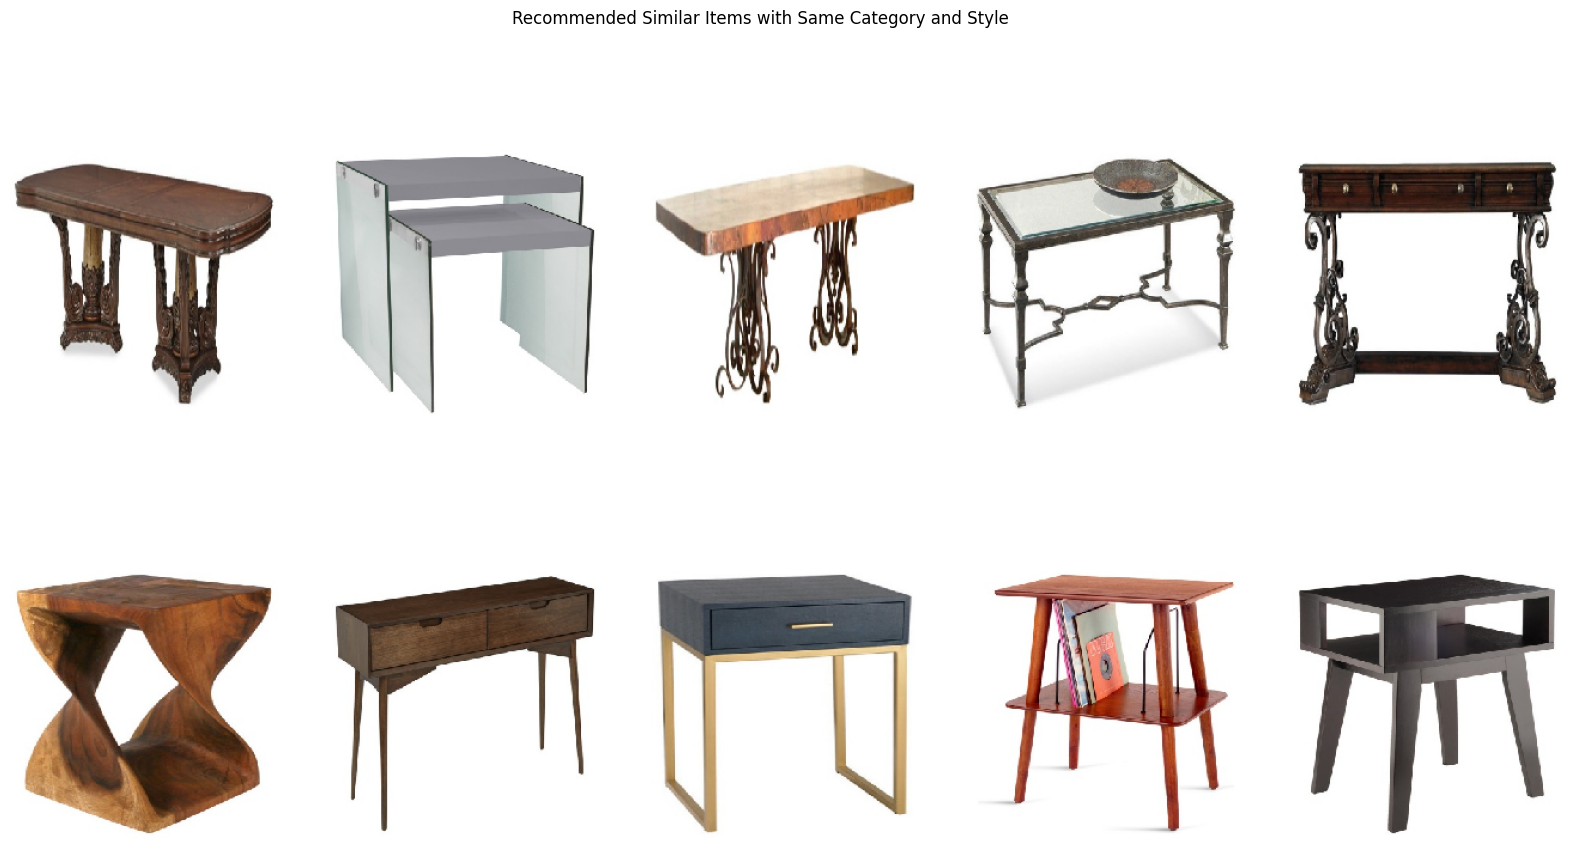

In [12]:

def display_images(indices, title):
    plt.figure(figsize=(20, 10))
    plt.suptitle(title)
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(load_img(image_paths[idx], target_size=(224, 224)))
        plt.axis('off')
    plt.show()


def upload_and_recommend():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img_path = fn
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0
        similar_indices = recommend_similar_items_with_category_and_style(img_array, features_category, features_style)
        display_images(similar_indices, "Recommended Similar Items with Same Category and Style")

upload_and_recommend()